In [2]:
import logging
import threading
import itertools
#import modin.pandas as pd  
import pandas as pd
import numpy as np  
import scipy as sp
import json
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.dbtables import FileModelStore
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.bif import PythonExpression
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from mmfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore, SpectralAnomalyScoreExt,
                 SaliencybasedGeneralizedAnomalyScoreV2, FFTbasedGeneralizedAnomalyScoreV2, 
                 KMeansAnomalyScoreV2, BayesRidgeRegressor, BayesRidgeRegressorExt)
from mmfunctions.anomaly import (FeatureBuilder, GBMRegressor, GBMForecaster, KDEAnomalyScore, VIAnomalyScore)
from poc.functions import State_Timer
import datetime as dt
import pymc3 as pm
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
import arviz as az
register_matplotlib_converters()


In [3]:
max_april_day = np.array([23.1, 22.1, 24.9, 26.4, 26.0, 23.1, 24.2, 18.8, 22.3, 24.7, 23.3, 25.0, 
                          25.0, 26.1, 27.0, 27.0, 26.0, 26.7, 25.8, 27.1, 29.3, 30.9, 30.4, 27.6,
                          29.3, 28.1, 28.0, 30.7, 28.6, 30.])
avg_april_day = np.array([11.3, 11.2, 11.1, 12.1, 12.0, 11.7, 11.5, 11.4, 12.2, 12.3, 12.1, 12.7,
                          12.8, 13.4, 13.4, 13.7, 14.5, 14.0, 14.4, 14.3, 13.8, 14.1, 14.1, 14.9,
                          15.2, 15.7, 15.7, 15.2, 15.5, 15.6])
min_april_day = np.array([2.7, 4.1, 1.6, 0.5, 0.7, 2.1, 2.6, 4.1, 3.1, 2.3, 1.0, 3.1, 3.6, 4.5,
                          1.2, 5.4, 3.4, 5.0, 2.7, 4.4, 3.4, 4.8, 4.3, 5.4, 6.3, 6.8, 3.2, 5.5, 6.6, 7.0])

max_may_day = np.array([27.7, 31.3, 29.0, 28.5, 30.1, 30.0, 27.5, 28.3, 28.1, 29.0, 28.4, 28.9, 29.0, 30.5,
                        29.4, 31.5, 31.8, 32.0, 30.1, 30.8, 32.4, 31.0, 31.2, 33.2, 32.1, 30.7, 30.7, 33.3,
                        32.2, 32.4, 32.7])
avg_may_day = np.array([15.9, 16.5, 16.0, 17.0, 17.2, 18.0, 17.4, 17.2, 17.6, 16.8, 17.5, 18.7, 19.2, 19.2,
                        18.9,19.2, 19.4, 19.1, 18.7, 18.7, 19.4, 19.9, 20.4, 20.8, 19.8, 20.8, 19.4, 20.0,
                        20.5, 20.8, 21.2])
min_may_day = np.array([5.1, 7.1, 3.8, 4.8, 5.6, 6.5, 7.2, 6.6, 7.8, 7.1, 6.8, 6.6, 7.7, 9.4, 7.6, 9.7,
                        10.0, 9.1, 11.6, 9.7, 10.5, 9.4, 11.7, 9.7, 11.1, 11.4, 10.4, 10.0, 9.4, 10.6, 11.2])

In [4]:
april_start = dt.datetime(2020, 4, 1)
april_end = dt.datetime(2020, 4, 30)
may_start = dt.datetime(2020, 5, 1)
may_end = dt.datetime(2020, 5, 31)
df_april = pd.DataFrame(index=pd.date_range(april_start, april_end), columns = ['max', 'avg', 'min'])
df_may = pd.DataFrame(index=pd.date_range(may_start, may_end), columns = ['max', 'avg', 'min'])

In [5]:
df_april['max'] = max_april_day
df_april['avg'] = avg_april_day
df_april['min'] = min_april_day
df_may['max'] = max_may_day
df_may['avg'] = avg_may_day
df_may['min'] = min_may_day

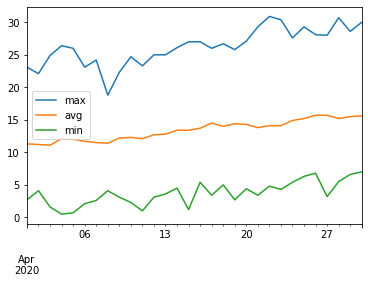

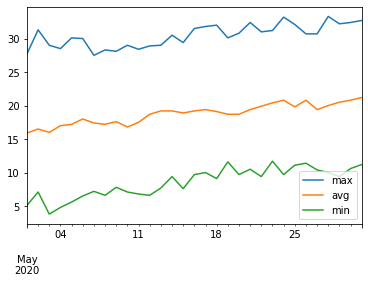

In [6]:
df_april.plot()
df_may.plot()

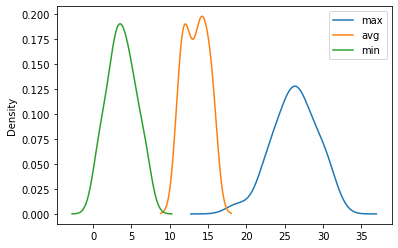

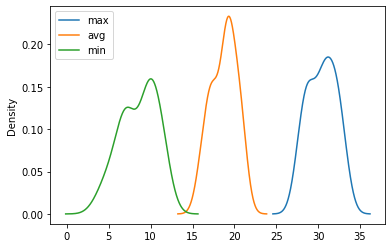

In [7]:
df_april.plot.density()
df_may.plot.density()

In [8]:
temp_april_2020 = np.array([11,11,11,13,16,22,20,22,18,16,16,24,12,11,
                            16,18,18,17,13,15,17,18,21,23,15,29,22,24,18,19])
temp_may_2020 = np.array([18,15,15,12,12,17,17,22,23,24,16,12,15,14,16,16,19,
                          22,20,21,22,23,20,17,14,20,22,21,21,18])
temp_differences_2020 = temp_may_2020 - temp_april_2020

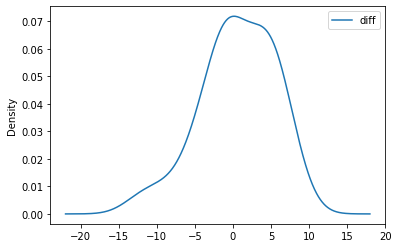

In [9]:
df = pd.DataFrame()
df['april'] = temp_april_2020
df['may'] = temp_may_2020
df['diff'] = temp_may_2020 - temp_april_2020
df[['diff']].plot.density()

In [10]:
sp.stats.ttest_ind(temp_may_2020, temp_april_2020)

Ttest_indResult(statistic=0.5703123369944323, pvalue=0.570668700407855)

Applying Bayes' theory to our problem where we want to know the means of samples given some data we get P(mean.1|sample.1) ∝ P(sample.1|mean.1)∗P(mean.1). 
The first term on the right is the likelihood, P(sample.1|mean.1), which is the probability of observing the sample data given mean.1. The second term is the prior, P(mean.1), which is simply the probability of mean.1. 
Figuring out appropriate priors is still a bit of an art and is one of the biggest critisims of Bayesian methods.

In [11]:
'''
https://docs.pymc.io/notebooks/BEST.html
following
Kruschke, J. (2012) Bayesian estimation supersedes the t-test. Journal of Experimental Psychology: General.
'''
y = np.concatenate([temp_april_2020, temp_may_2020])

μ_m = y.mean()
μ_s = y.std() * 2

with pm.Model() as model:
    group1_mean = pm.Normal("group1_mean", mu=μ_m, sd=μ_s)
    group2_mean = pm.Normal("group2_mean", mu=μ_m, sd=μ_s)
    
σ_low = 1
σ_high = 100

with model:
    group1_std = pm.Uniform("group1_std", lower=σ_low, upper=σ_high)
    group2_std = pm.Uniform("group2_std", lower=σ_low, upper=σ_high)

with model:
    ν = pm.Exponential("ν_minus_one", 1 / 29.0) + 1

with model:
    λ1 = group1_std ** -2
    λ2 = group2_std ** -2
    

    group1 = pm.StudentT("april", nu=ν, mu=group1_mean, lam=λ1, observed=temp_april_2020)
    group2 = pm.StudentT("may", nu=ν, mu=group2_mean, lam=λ2, observed=temp_may_2020)

with model:
    diff_of_means = pm.Deterministic("difference of means", group2_mean - group1_mean)
    diff_of_stds = pm.Deterministic("difference of stds", group2_std - group1_std)
    effect_size = pm.Deterministic(
        "effect size", diff_of_means / np.sqrt((group1_std ** 2 + group2_std ** 2) / 2)
    )


In [12]:
print(model)

          group1_mean ~ Normal
          group2_mean ~ Normal
group1_std_interval__ ~ TransformedDistribution
group2_std_interval__ ~ TransformedDistribution
    ν_minus_one_log__ ~ TransformedDistribution
           group1_std ~ Uniform
           group2_std ~ Uniform
          ν_minus_one ~ Exponential
  difference of means ~ Deterministic
   difference of stds ~ Deterministic
          effect size ~ Deterministic
                april ~ StudentT
                  may ~ StudentT


In [13]:
with model:
    trace = pm.sample(4000)

<ipython-input-13-c355d80c3c1e>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(4000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, group2_std, group1_std, group2_mean, group1_mean]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 18 seconds.


In [14]:
np.count_nonzero(trace["diverging"])

0

/home/markus/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


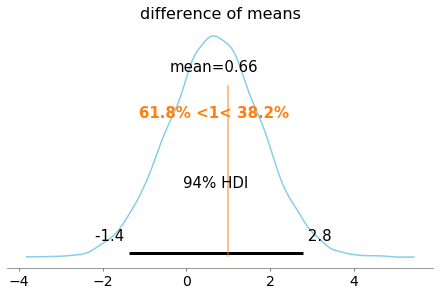

In [15]:
# 38.1 % chances that a day May is more than 1° degree warmer than its "counterpart" in April
pm.plot_posterior(
    trace,
    var_names=["difference of means"], #, "difference of stds", "effect size"],
    ref_val=1,
    color="#87ceeb",
);

/home/markus/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


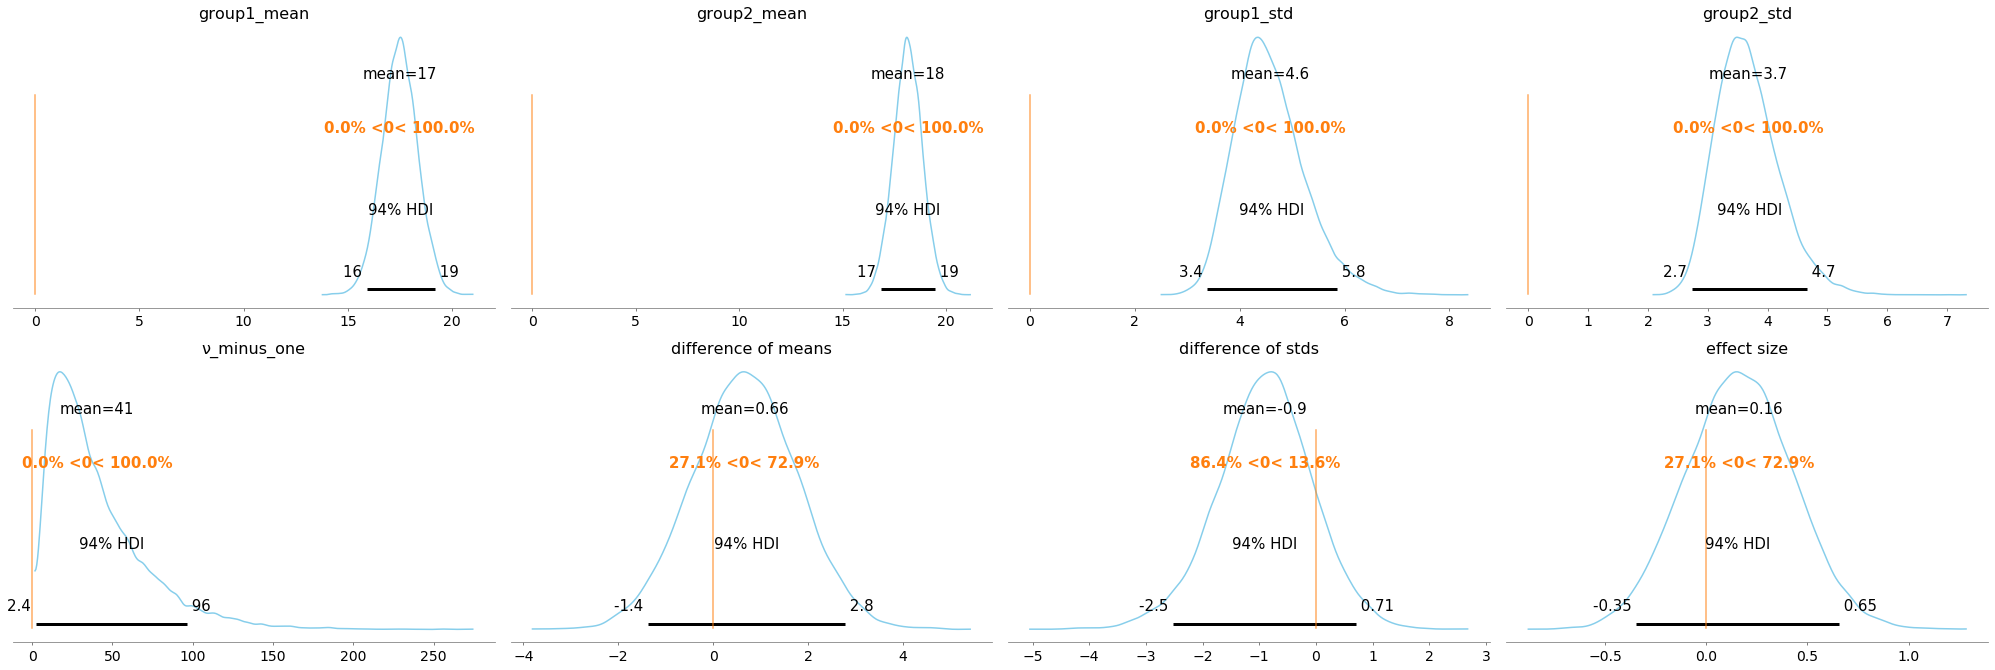

In [16]:
pm.plot_posterior(
    trace,
    #var_names=["difference of means"], #, "difference of stds", "effect size"],
    ref_val=0,
    color="#87ceeb",
);

In [17]:
with model:
    ppc = pm.sample_posterior_predictive(
        trace, var_names=["ν_minus_one", "group2_std", "group1_std", "group2_mean", "group1_mean", "april", "may"], random_seed=42
    )

/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


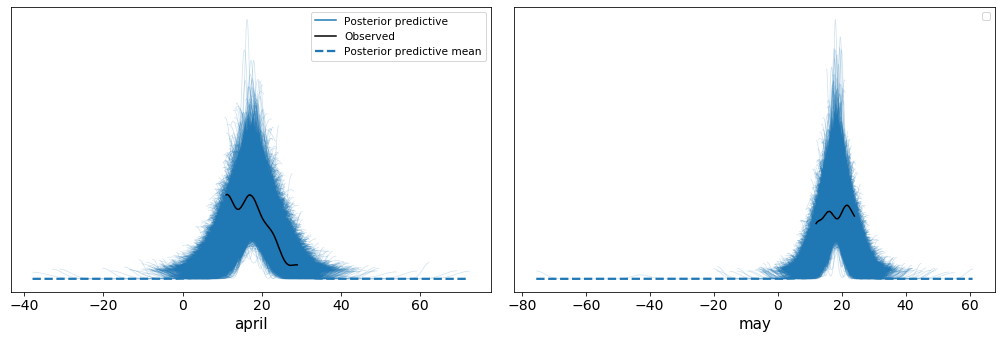

In [18]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model));

In [19]:
with model:
    advi = pm.ADVI()
    mean_field = advi.fit(20000)

Finished [100%]: Average Loss = 181.87


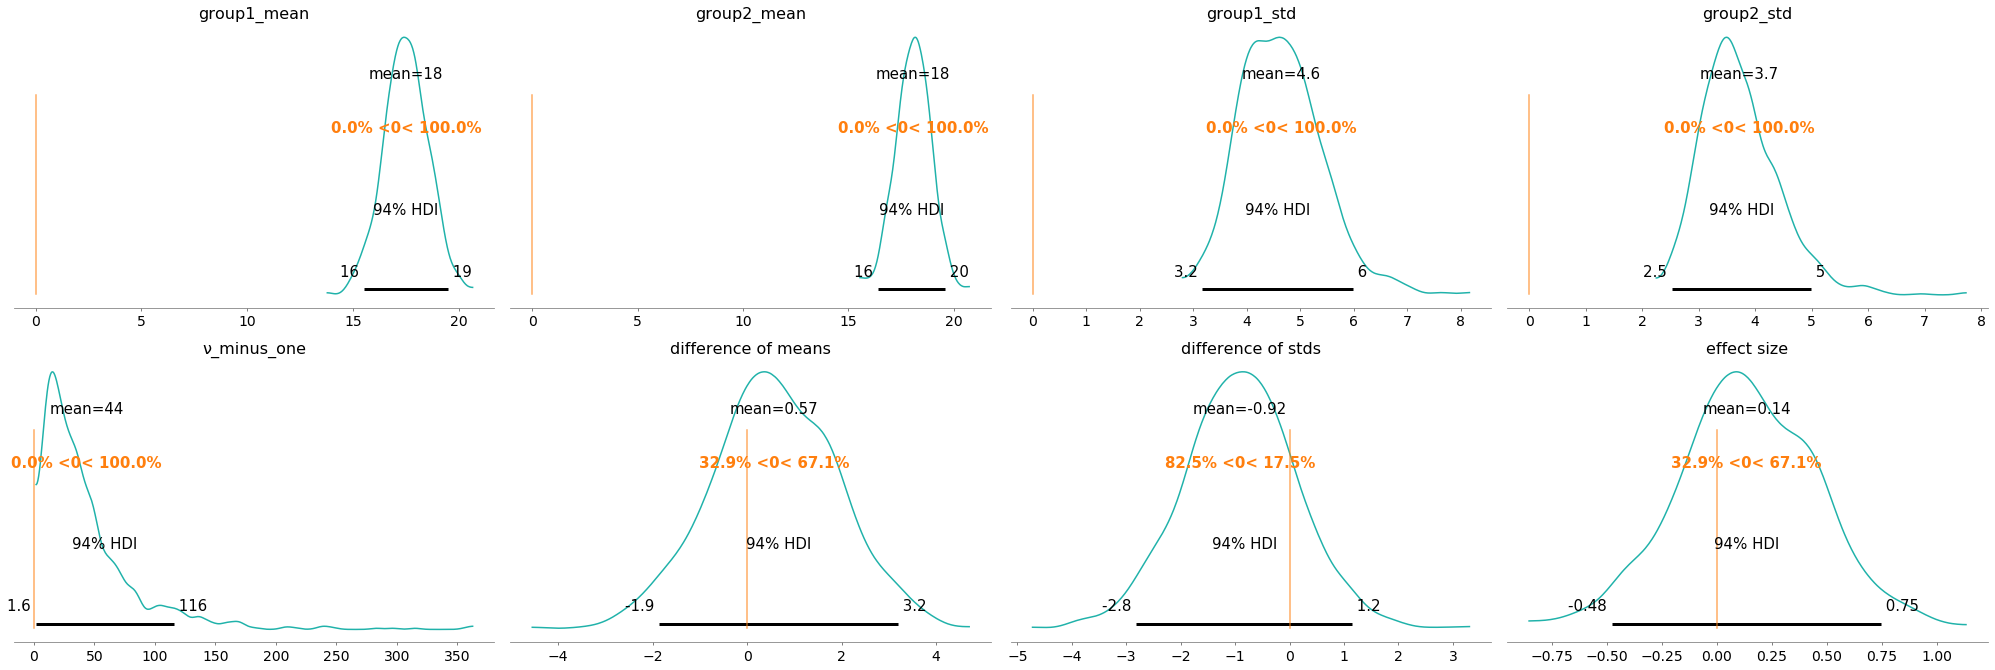

In [20]:
with model:
    pm.plot_posterior(
        mean_field.sample(1000), 
        ref_val=0,
        color="LightSeaGreen");

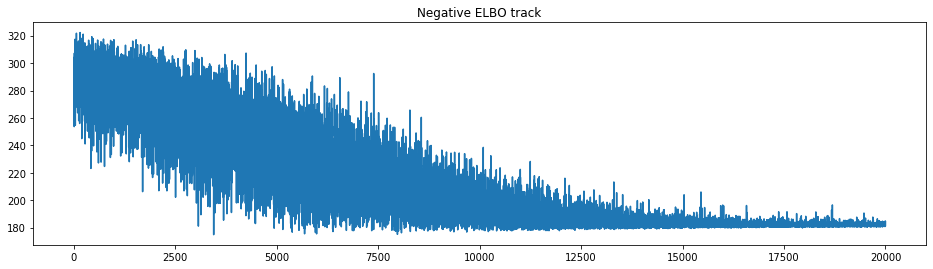

In [21]:
fig = plt.figure(figsize=(16, 9))
elbo_ax = fig.add_subplot(212)
elbo_ax.plot(mean_field.hist)
elbo_ax.set_title("Negative ELBO track");


In [ ]:
pm.plot_posterior(
    trace,
    #var_names=["difference of means"], #, "difference of stds", "effect size"],
    ref_val=0,
    color="#87ceeb",
);

/home/markus/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


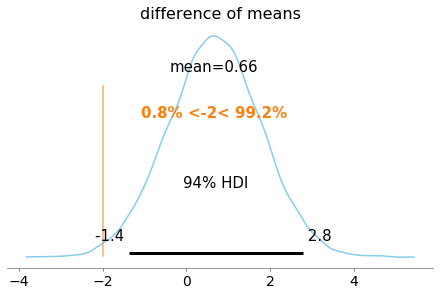

In [22]:
# 37.7 % chances that a day in May is 1° degree warmer than its "counterpart" in April
cppc_trace = pm.sample_posterior_predictive(trace, var_names=["x_obs"])

<ipython-input-23-166c45da2bbd>:1: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  pm.forestplot(trace, var_names=["difference of means", "difference of stds", "effect size"]);
/home/markus/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


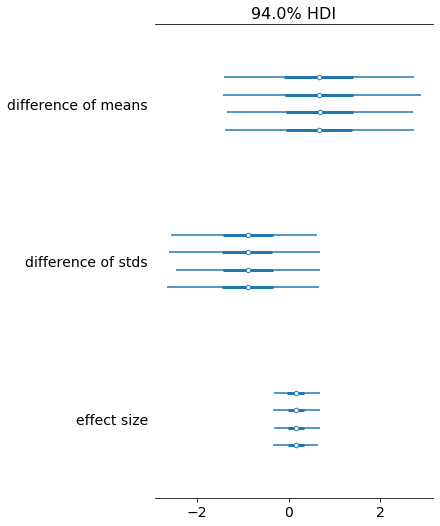

In [23]:
pm.forestplot(trace, var_names=["difference of means", "difference of stds", "effect size"]);

In [25]:
pm.summary(trace) #, varnames=["difference of means", "difference of stds", "effect size"])

/home/markus/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
group1_mean,17.490,0.862,15.919,19.164,0.006,0.004,22725.0,12374.0,1.0
group2_mean,18.155,0.698,16.837,19.467,0.005,0.004,18517.0,13202.0,1.0
group1_std,4.577,0.672,3.385,5.848,0.005,0.004,18857.0,12379.0,1.0
group2_std,3.672,0.530,2.733,4.664,0.004,0.003,21007.0,13089.0,1.0
ν_minus_one,40.505,30.742,2.364,96.394,0.231,0.187,17744.0,11263.0,1.0
difference of means,0.664,1.111,-1.379,2.774,0.008,0.007,20432.0,12724.0,1.0
difference of stds,-0.904,0.853,-2.525,0.712,0.006,0.005,19559.0,12569.0,1.0
effect size,0.162,0.267,-0.348,0.654,0.002,0.002,21010.0,13240.0,1.0


/home/markus/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f312d5d7d00>,
      dtype=object)

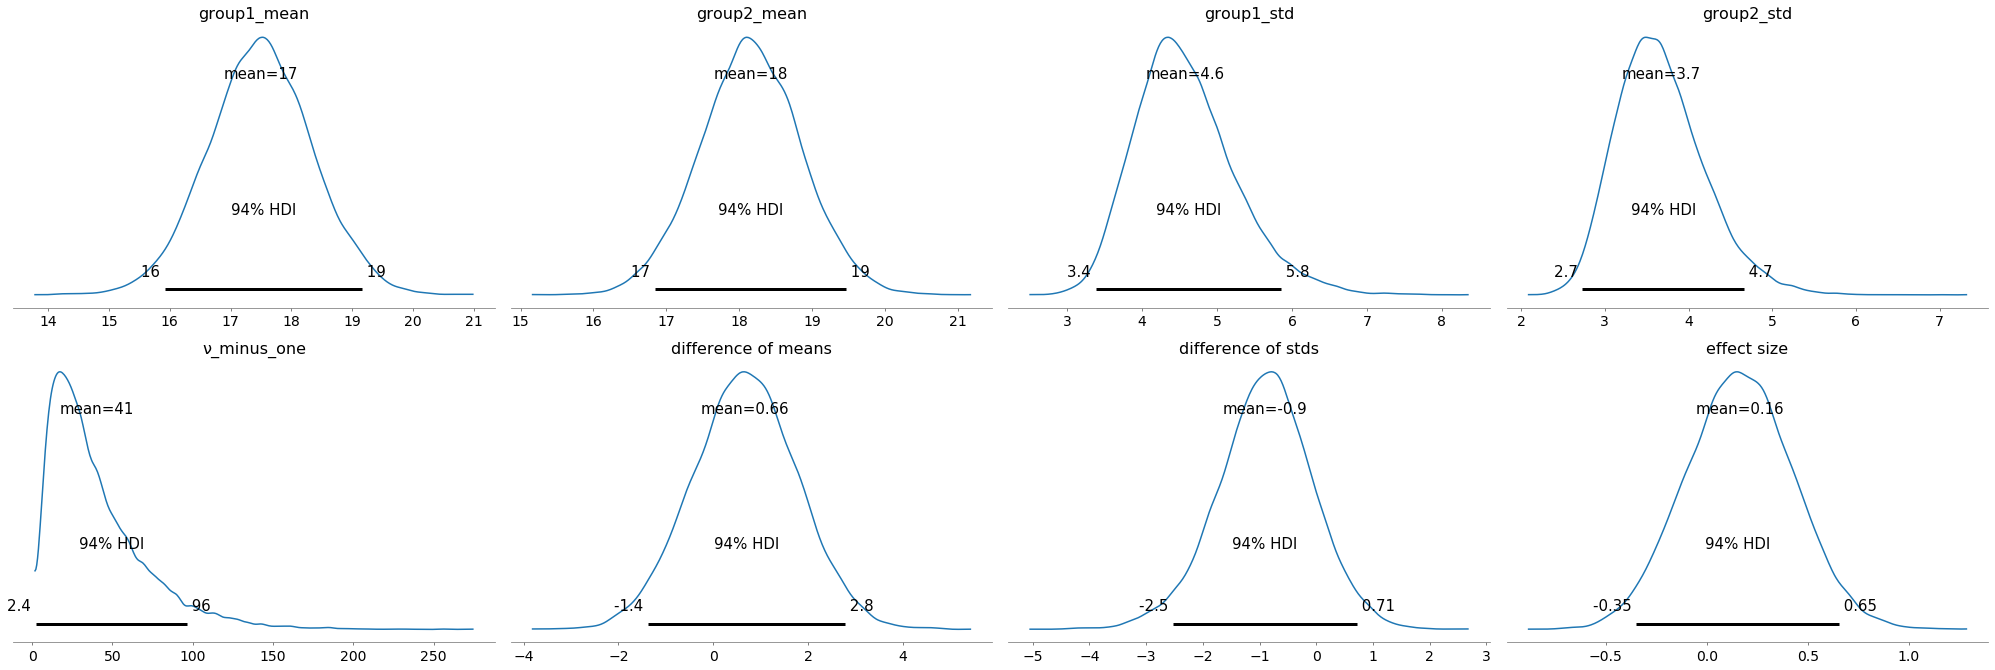

In [26]:
az.plot_posterior(trace) #, var_names=['std','nu'], filter_vars='like')

In [29]:
N = 1000

W = np.array([0.35, 0.4, 0.25])

MU = np.array([0.0, 2.0, 5.0])
SIGMA = np.array([0.5, 0.5, 1.0])

component = np.random.choice(MU.size, size=N, p=W)
x = np.random.normal(MU[component], SIGMA[component], size=N)

In [30]:
with pm.Model() as model2:
    w = pm.Dirichlet("w", np.ones_like(W))

    mu = pm.Normal("mu", 0.0, 10.0, shape=W.size)
    tau = pm.Gamma("tau", 1.0, 1.0, shape=W.size)

    x_obs = pm.NormalMixture("x_obs", w, mu, tau=tau, observed=x)

In [57]:
with model2:
    # NUTS
    trace = pm.sample(5000, n_init=10000, init='advi', tune=1000)

<ipython-input-57-a098e9a1118a>:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, n_init=10000, init='advi', tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Finished [100%]: Average Loss = 2,180.7
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, mu, w]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 26 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [58]:
with model2:
    # ADVI
    advi2 = pm.ADVI()
    mean_field2 = advi2.fit(200000)

Finished [100%]: Average Loss = 1,931


In [59]:
with model2:
    # sample posterior predictive samples
    ppc_trace = pm.sample_posterior_predictive(trace, var_names=["x_obs"])   

In [60]:
with model2:
    # Get an arviz inference object
    idata_pymc3 = az.from_pymc3(trace, posterior_predictive=ppc_trace)

In [61]:
with model2:
    trace4 = mean_field2.sample(3000)
    ppc_trace2 = pm.sample_posterior_predictive(trace4, var_names=["x_obs"])
    idata_pymc32 = az.from_pymc3(trace4, posterior_predictive=ppc_trace2)

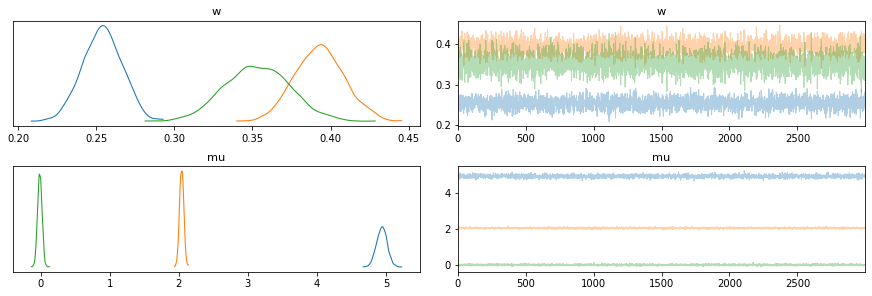

In [62]:
az.plot_trace(idata_pymc32, var_names=["w", "mu"]);

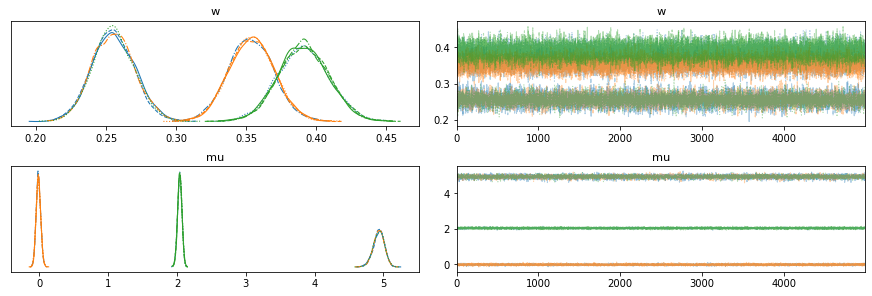

In [63]:
az.plot_trace(idata_pymc3, var_names=["w", "mu"]);